# Курсовой проект по кусрсу "Библиотеки Python для Data Science: продолжение"

## **1. Постановка задачи**

#### **Задача:**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### **Наименование файлов с данными:**

##### **course_project_train.csv** - обучающий датасет
##### **course_project_test.csv** - тестовый датасет



#### **Целевая переменная:**

Credit Default - факт невыполнения кредитных обязательств

#### **Метрика качества:**

F1-score (sklearn.metrics.f1_score)



#### **Подключение библиотек и скриптов:**

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# import pickle
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm
# import scipy.stats as stats


from sklearn.model_selection import train_test_split # , ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report # , f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV # , RandomizedSearchCV
#  from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression # , LogisticRegressionCV
# from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler # MinMaxScaler
from sklearn.model_selection import train_test_split # , ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV # , RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier # , CatBoostRegressor, Pool

# from pathlib import Path

# from scipy.stats import shapiro
# from scipy.stats import probplot
# from scipy.stats import mannwhitneyu
# from scipy.stats import chi2_contingency

# import statsmodels.api as sm
# from statsmodels.formula.api import ols

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def reduce_mem_usage(df):
    """ Modify the data type to reduce memory usage. """
    start_memory = df.memory_usage().sum() / 1024**2
    print(f'Dataframe memory usage: {round(start_memory, 2)} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':            
                if c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            
    finish_memory = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization: {round(finish_memory, 2)} MB')
    
    return df

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

#### **Пути к файлам:**

In [5]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

## **2. Получение baseline.**

### **Загрузка данных и обзор датасета.**

#### **Описание датасета:**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [7]:
train_df.shape

(7500, 17)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Понижения размера пямяти датафрейма:**

In [9]:
# train_df = reduce_mem_usage(train_df)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


**Сравнение количества признаков в датафреймах:**

In [12]:
train_df.shape[1] - 1 == test_df.shape[1]

True

**Проверка датафрейма на наличие пропусков:**

In [13]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

**Просмотр статистических данных числовых признаков:**

In [14]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [15]:
# train_df.info()

**Разделение признаков на числовые и категориальные:**

In [16]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()
NUM_FEATURE_NAMES = [col for col in train_df.columns if str(train_df[col].dtype) != 'object']
CAT_FEATURE_NAMES = [col for col in train_df.columns if str(train_df[col].dtype) == 'object']

print(f'NUM_FEATURE_NAMES (count - {len(NUM_FEATURE_NAMES)}):\n {NUM_FEATURE_NAMES},\n\nCAT_FEATURE_NAMES (count - {len(CAT_FEATURE_NAMES)}):\n{CAT_FEATURE_NAMES}\n\n')

NUM_FEATURE_NAMES (count - 13):
 ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Credit Default'],

CAT_FEATURE_NAMES (count - 4):
['Home Ownership', 'Years in current job', 'Purpose', 'Term']




**Построение гистограм распределения числовых признаков:**

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>],
       [<AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>],
       [<AxesSubplot:title={'center':'Credit Default'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

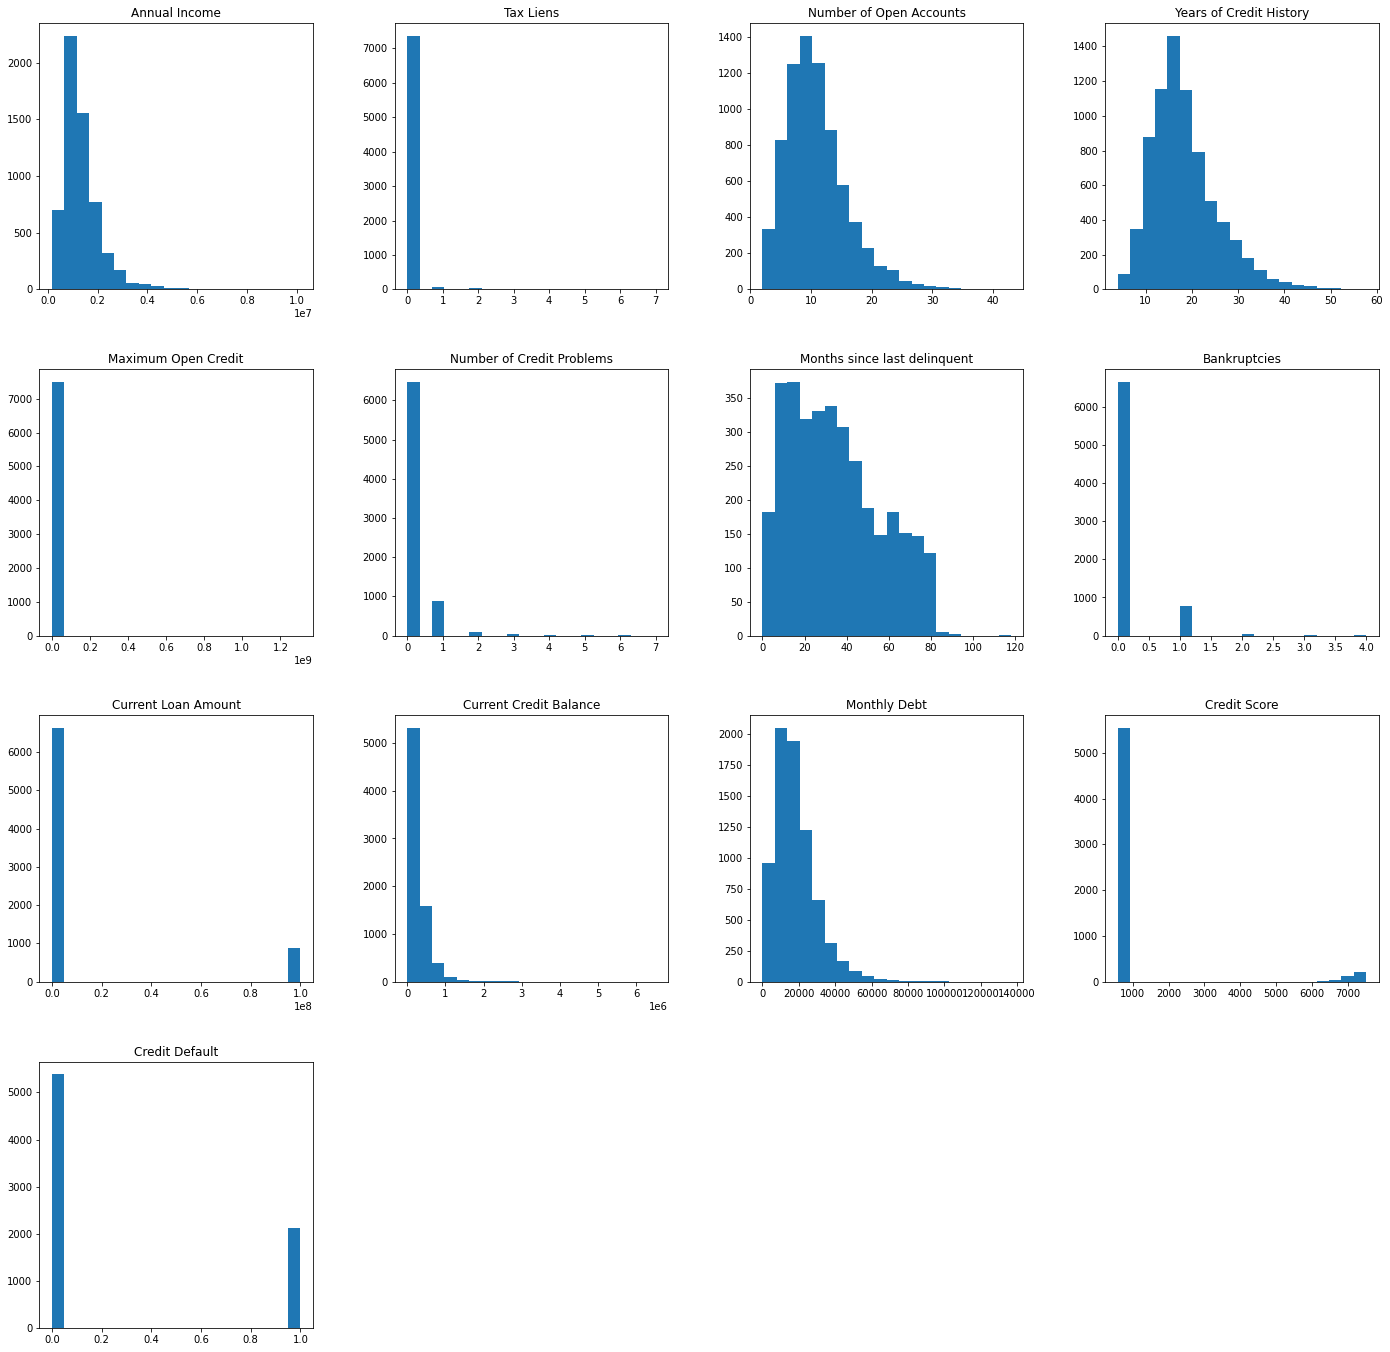

In [17]:
train_df.hist(figsize=(24, 24), bins=20, grid=False)

### **Анализ целевой переменной.**

**Озор распределения:**

In [18]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

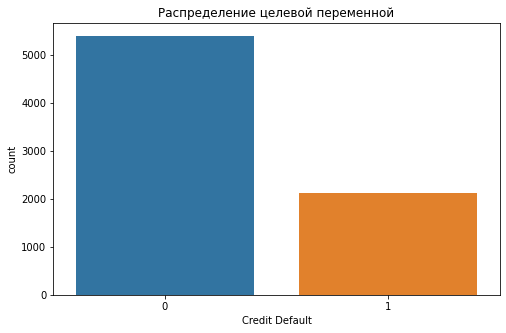

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(x=TARGET_NAME, data=train_df)

plt.title('Распределение целевой переменной')
plt.show()

**Кореляция целевой переменной с базовыми признаками:**

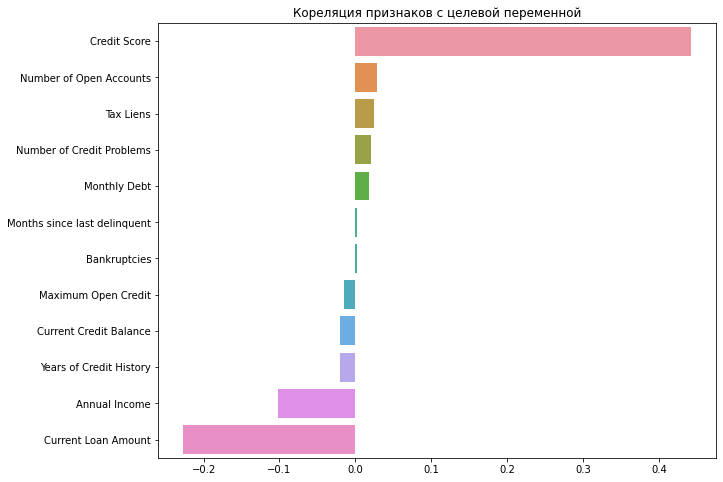

In [20]:
corr_with_target = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Кореляция признаков с целевой переменной')
plt.show()

**При первоначальном анализе датасета видны следующие аномалии:**
* Имеются пропуски в следующих признаках:
    - Annual Income, 
    - Years in current job,
    - Months since last delinquent,
    - Credit Score,
    - Bankruptcies
* Имеются выбросы в следующих признаках:
    - Current Loan Amount (100,000,000.00),
        

### **Первичная обработка пропусков и выбросов.**

Пропуски в Annual Income могут свидетельствовать о неизвестном доходе. В таком случае заполним эти пропуски медианами.

In [21]:
train_df['Annual Income'].fillna(train_df['Annual Income'].median(), inplace=True)

Для заполнения пропусков в признаке "Years in current job" приведем значения этого признака к числовым данным.
При этом пропуски заполним 0.

In [22]:
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [23]:
train_df['Years in current job'].fillna(0, inplace=True)


In [24]:
train_df.loc[train_df['Years in current job'] == '< 1 year',  'Years in current job'] = 0
train_df.loc[train_df['Years in current job'] == '1 year',  'Years in current job'] = 1
train_df.loc[train_df['Years in current job'] == '10+ years',  'Years in current job'] = 10

for i in range(2, 11):
    train_df.loc[train_df['Years in current job'] == f'{i} years',  'Years in current job'] = i

train_df['Years in current job'] = train_df['Years in current job'].astype(np.int32)

train_df['Years in current job'].value_counts()

10    2332
0      934
2      705
3      620
5      516
1      504
4      469
6      426
7      396
8      339
9      259
Name: Years in current job, dtype: int64

При заполнении пропусков значенией признака "Months since last delinquent" предположим. что пропуск это отсутствие просрочки.

In [25]:
train_df['Months since last delinquent'].fillna(0, inplace=True)

Пропуски в признаке Credit Score заполним медианами.

In [26]:
train_df['Credit Score'].fillna(train_df['Credit Score'].median(), inplace=True)

В признаке "Current Loan Amount" удаляем выбросы и заменяем их медианами.

In [27]:
train_df.loc[(train_df['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = train_df['Current Loan Amount'].median()

В признаке "Bankruptcies" предположим, что пропуски значений это отсутствие банкротств.

In [28]:
train_df['Bankruptcies'].fillna(0, inplace=True)

In [29]:
train_df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int32  
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Кореляция целевой переменной с базовыми признаками**

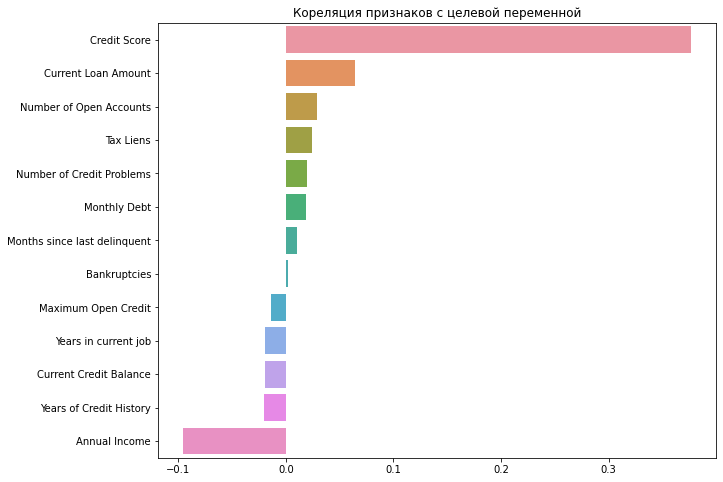

In [31]:
corr_with_target = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Кореляция признаков с целевой переменной')
plt.show()

#### **Создание класса для предобработки данных.**

In [32]:
class DataPreprocessing:
    def __init__(self):
        pass
   
    def transform(self, df):
              
        # Заполнение пропусков в 'Annual Income' медианами.        
        df['Annual Income'].fillna(df['Annual Income'].median(), inplace=True)

        # Заполнение пропусков в 'Years in current job' нулями.
        df['Years in current job'].fillna(0, inplace=True)

        # Перевод значений признака 'Years in current job' из object в int32.
        df.loc[df['Years in current job'] == '< 1 year',  'Years in current job'] = 0
        df.loc[df['Years in current job'] == '1 year',  'Years in current job'] = 1
        df.loc[df['Years in current job'] == '10+ years',  'Years in current job'] = 10

        for i in range(2, 11):
            df.loc[df['Years in current job'] == f'{i} years',  'Years in current job'] = i

        df['Years in current job'] = df['Years in current job'].astype(np.int32)

        # Заполнение пропусков в 'Months since last delinquent' нулями.
        df['Months since last delinquent'].fillna(0, inplace=True)

        # Заполнение пропусков в 'Credit Score' медианами.
        df['Credit Score'].fillna(df['Credit Score'].median(), inplace=True)

        # Удаляем выбросы и заполняем их медианами в приззнаке 'Current Loan Amount'.
        df.loc[(df['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = df['Current Loan Amount'].median()

        # Заполняем пропуски 'Bankruptcies' в нулями.
        df['Bankruptcies'].fillna(0, inplace=True)
        
        return df


In [33]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()
NUM_FEATURE_NAMES = [col for col in train_df.columns if str(train_df[col].dtype) != 'object']
CAT_FEATURE_NAMES = [col for col in train_df.columns if str(train_df[col].dtype) == 'object']

print(f'NUM_FEATURE_NAMES (count - {len(NUM_FEATURE_NAMES)}):\n {NUM_FEATURE_NAMES},\n\nCAT_FEATURE_NAMES (count - {len(CAT_FEATURE_NAMES)}):\n{CAT_FEATURE_NAMES}\n\n')

NUM_FEATURE_NAMES (count - 14):
 ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Credit Default'],

CAT_FEATURE_NAMES (count - 3):
['Home Ownership', 'Purpose', 'Term']




**Построение матрицы корреляции**

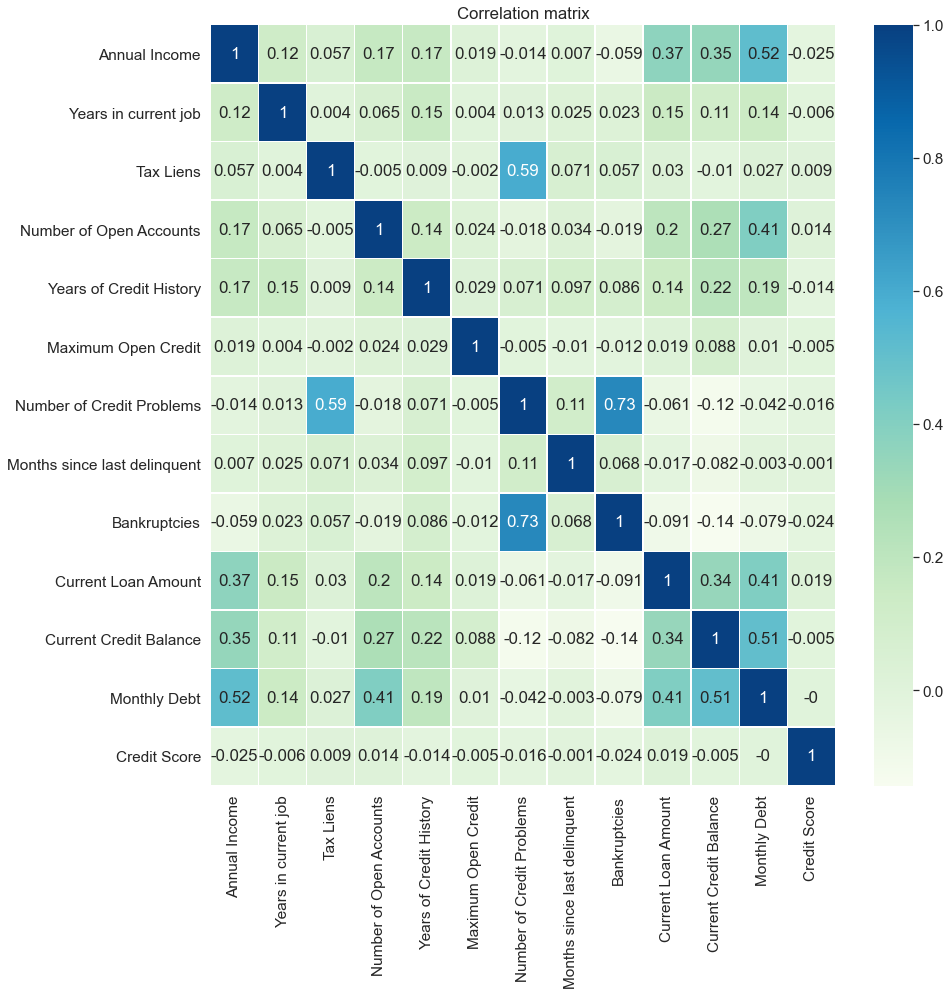

In [34]:
plt.figure(figsize = (14,14))

sns.set(font_scale=1.4)
sns.heatmap(train_df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [35]:
# Здесь должен был быть раздел для генерации новых признаков. 
# Но, т.к. Вы читаете этот комментарий, значит я делал проект в последний момент и не успел как следует поработать с признаками.

### **Построение моделей.**

**Создаем копию датафрейма:**

In [36]:
train_df_1 = train_df.copy()
train_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int32  
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Разделение на тренировочную и валидационную выборки.**

Т.к. для выработки baseline сначала строить модели при помощи логистической регрессии и К ближайших соседей, 
то на этом этапе будем использовать тольео числовые признаки датафрейма.

In [37]:
X = train_df[NUM_FEATURE_NAMES].drop(columns=TARGET_NAME)
y = train_df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=21)

**Нормализация:**

In [38]:
scaler = StandardScaler()

norm_df = train_df.copy()
norm_df = scaler.fit_transform(norm_df[NUM_FEATURE_NAMES])

train_df = norm_df.copy()


**Балансировка:**

In [39]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)

df_balanced[TARGET_NAME].value_counts()

0    4046
1    3158
Name: Credit Default, dtype: int64

In [40]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]


**Логистическая регрессия:**

In [41]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.65      0.80      0.71      4046
           1       0.63      0.44      0.52      3158

    accuracy                           0.64      7204
   macro avg       0.64      0.62      0.62      7204
weighted avg       0.64      0.64      0.63      7204

TEST

              precision    recall  f1-score   support

           0       0.77      0.80      0.79      1341
           1       0.45      0.42      0.43       534

    accuracy                           0.69      1875
   macro avg       0.61      0.61      0.61      1875
weighted avg       0.68      0.69      0.69      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1071  270
1                312  222


**К ближайших соседей:**

In [42]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.81      0.79      4046
           1       0.74      0.67      0.70      3158

    accuracy                           0.75      7204
   macro avg       0.75      0.74      0.74      7204
weighted avg       0.75      0.75      0.75      7204

TEST

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1341
           1       0.34      0.39      0.37       534

    accuracy                           0.61      1875
   macro avg       0.54      0.55      0.54      1875
weighted avg       0.63      0.61      0.62      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               941  400
1               324  210


**XGBoost**

In [43]:
model_xgb = xgb.XGBClassifier(random_state=11)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[10:13:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4046
           1       0.97      0.96      0.97      3158

    accuracy                           0.97      7204
   macro avg       0.97      0.97      0.97      7204
weighted avg       0.97      0.97      0.97      7204

TEST

              precision    recall  f1-score   support

           0       0.79      0.85      0.81      1341
           1       0.52      0.42      0.46       534

    accuracy                           0.72      1875
   macro avg       0.65      0.63      0.64      1875
weighted avg       0.71      0.72      0.71      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0          

**LightGBM**

In [44]:
model_lgbm = lgbm.LGBMClassifier(random_state=11)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      4046
           1       0.94      0.90      0.92      3158

    accuracy                           0.93      7204
   macro avg       0.93      0.93      0.93      7204
weighted avg       0.93      0.93      0.93      7204

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1341
           1       0.53      0.46      0.50       534

    accuracy                           0.73      1875
   macro avg       0.66      0.65      0.66      1875
weighted avg       0.72      0.73      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1122  219
1                286  248


**CatBoost**

In [45]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=11)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      4046
           1       0.93      0.84      0.88      3158

    accuracy                           0.90      7204
   macro avg       0.91      0.90      0.90      7204
weighted avg       0.90      0.90      0.90      7204

TEST

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1341
           1       0.55      0.45      0.49       534

    accuracy                           0.74      1875
   macro avg       0.67      0.65      0.66      1875
weighted avg       0.72      0.74      0.73      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1145  196
1                296  238


** **

#### **Вывод по baseline:**

Из приведенных вычислений видно, что построение моделей только лишь на числовых признаках, 
без кодирования категориальных, метрики качества на валидационной выборке получаются низкими.
Так же сильно переобучение.
Так же становится очевидным, что сильная сторона CatBoost нивелируется за счет неприменения категориальных признаков при обучении модели.

#### **Обучим модель CatBoost на датафрейме с учетом категориальных признаков.**

In [46]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

**Разделяем датафрейм на тестовую и валидационную выборки:**

In [47]:
X_1 = train_df_1[BASE_FEATURE_NAMES]
y_1 = train_df_1[TARGET_NAME]

X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, shuffle=True, random_state=21)


**Производим нормализацию цисловых признаков:**

In [48]:
scaler_1 = StandardScaler()

norm_df_1 = train_df_1.copy()
norm_df_1[NUM_FEATURE_NAMES] = scaler.fit_transform(norm_df_1[NUM_FEATURE_NAMES])

train_df_1 = norm_df_1.copy()


**Производим балансировку классов:**

In [49]:
df_for_balancing_1 = pd.concat([X_1_train, y_1_train], axis=1)

df_for_balancing_1

df_balanced_1 = balance_df_by_target(df_for_balancing_1, TARGET_NAME)


In [50]:
X_1_train = df_balanced_1.drop(columns=TARGET_NAME)
y_1_train = df_balanced_1[TARGET_NAME]


**Обучаем модель CatBoost на выборке с учетом категориальных перименных:**

In [51]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, cat_features=CAT_FEATURE_NAMES)
model_catb.fit(X_1_train, y_1_train)

y_1_train_pred = model_catb.predict(X_1_train)
y_1_test_pred = model_catb.predict(X_1_test)

get_classification_report(y_1_train, y_1_train_pred, y_1_test, y_1_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4046
           1       0.93      0.82      0.87      3158

    accuracy                           0.89      7204
   macro avg       0.90      0.88      0.89      7204
weighted avg       0.89      0.89      0.89      7204

TEST

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1341
           1       0.57      0.46      0.51       534

    accuracy                           0.75      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.73      0.75      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1156  185
1                290  244


#### **Вывод по CatBoost:**

Очевидно, что "скармливая" алгоритму категориальные признаки, обучение модели происходит точнее.

### **Подбор параметров для финальной модели.**

In [52]:
# Здесь должен был быть применен GridSearchCV, но т.к. работа над курсовым проектом велась в последний момент, выбрал параметры методом научного тыка.

In [53]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3, silent=True, random_state=11, cat_features=CAT_FEATURE_NAMES)

final_model.fit(X_1_train, y_1_train)

y_train_pred = final_model.predict(X_1_train)
y_test_pred = final_model.predict(X_1_test)

get_classification_report(y_1_train, y_1_train_pred, y_1_test, y_1_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4046
           1       0.93      0.82      0.87      3158

    accuracy                           0.89      7204
   macro avg       0.90      0.88      0.89      7204
weighted avg       0.89      0.89      0.89      7204

TEST

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1341
           1       0.57      0.46      0.51       534

    accuracy                           0.75      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.73      0.75      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1156  185
1                290  244


## **3. Подготовка тестового датасета**

In [54]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

**Предообработка датасета:**

In [55]:
preprocessor = DataPreprocessing()
test_df = preprocessor.transform(test_df)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   int32  
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [56]:
df_for_model = test_df
df_for_model

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1178475.0,4,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0
1,Rent,231838.0,1,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,322366.0,162735.0,15046.0,745.0
2496,Home Mortgage,1178475.0,2,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,731.0
2497,Home Mortgage,1171806.0,2,0.0,48.0,12.8,1706430.0,0.0,0.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10,0.0,14.0,28.8,945780.0,0.0,0.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


**Предсказание целевой переменной:**

In [57]:
y_pred_output = final_model.predict(df_for_model)

**Сохранение результата:**

In [58]:
result = pd.DataFrame({'Id': np.arange(2500), 'Credit Default': y_pred_output})

In [59]:
RESULT_PATH = './KungurovEA_predictions.csv'
result.to_csv(RESULT_PATH, index=False)

In [60]:
SAMPLE = './KungurovEA_predictions.csv'
df_sample = pd.read_csv(SAMPLE)

predictions = pd.DataFrame(index=df_sample['Id'])

predictions[TARGET_NAME] = y_pred_output
predictions

,Credit Default
Id,
0,0
1,1
2,1
3,0
4,0
...,...
2495,0
2496,1
2497,1


### **Заключение.**

**Очевидно, что здесь должны быть выводы по сравнению различных алгоритмов, с перечислением их достоинств и недостатков.
Но их не будет, т.к. проект выполнялся в последний момент и за один присест.
В данном проекте не очень тщательно производилась предобработка признаков и генерация новых с формированием и проверкой гипотез.
Так же подбор гиперпараметров для алгоритмов бустинга производился методом тыка, 
т.к. целью  первого прохода было получение минимально достаточных метрик качества, минимально рабочей модели.
Конечно, хотелось бы столкнуть лбами XGBoost и CatBoost, подобрать гиперпараметры и применить регуляризацию.
Единственный выод, который можно сделать в проекте, это, то что алгоритм CatBoost действительно показывает лучшие результаты прямо "из коробки".**